<a href="https://colab.research.google.com/github/ed-chin-git/DS-Unit-3-Sprint-3-Big-Data/blob/master/module1-aws-sagemaker/Unit_2_Kaggle_Competition_Tanzanian_Water_Pumps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # DS1 Unit 2 Project— Predictive Modeling
     
Intro [Video]( https://www.youtube.com/watch?v=NsKpvxpX_eU&feature=youtu.be)

Open Classroom Review [video](https://www.youtube.com/watch?v=4B4EP6eTzLk)


Reference Articles:


*   [Begin with baseline models](https://github.com/rrherr/baselines/blob/master/Begin%20with%20baseline%20models.ipynb)
*   [Visiting: Categorical Features and Encoding in Decision Trees](https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931)


## IMPORTS and EXPORTS

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, PowerTransformer
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import NuSVC


pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [0]:
!pip install -i https://test.pypi.org/simple/ lambdata-edchin==1.5.5

Looking in indexes: https://test.pypi.org/simple/
  Found existing installation: lambdata-edchin 1.5.4
    Uninstalling lambdata-edchin-1.5.4:
      Successfully uninstalled lambdata-edchin-1.5.4


In [0]:
import lambdata_edchin.pyxlib as pyx

In [0]:
def create_submission(pred_array,X_test_df,dest_url):
  pred_df=pd.DataFrame(pred_array,columns=['status_group'])
  pump_ids=pd.DataFrame(X_test_df.id,columns=['id'])
  pump_ids = pump_ids.astype('int32')
  submit_df=pd.concat([pump_ids, pred_df], axis=1)
  submit_df.to_csv(dest_url, index=False, header=['id','status_group'])
  return

## Load DATA

In [0]:
X_train_url = '/content/drive/My Drive/Colab Notebooks/train_features.csv'
y_train_url = '/content/drive/My Drive/Colab Notebooks/train_labels.csv'
X_test_url = '/content/drive/My Drive/Colab Notebooks/test_features.csv'
y_test_url = '/content/drive/My Drive/Colab Notebooks/sample_submission.csv'

train_features = pd.read_csv(X_train_url)
train_labels = pd.read_csv(y_train_url)
test_features = pd.read_csv(X_test_url)
sample_sub =pd.read_csv(y_test_url)

In [0]:
print(train_features.shape)
train_features.head()

In [0]:
train_labels.head()

###  Quick Viz inspired by Sir Ryan Herr

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


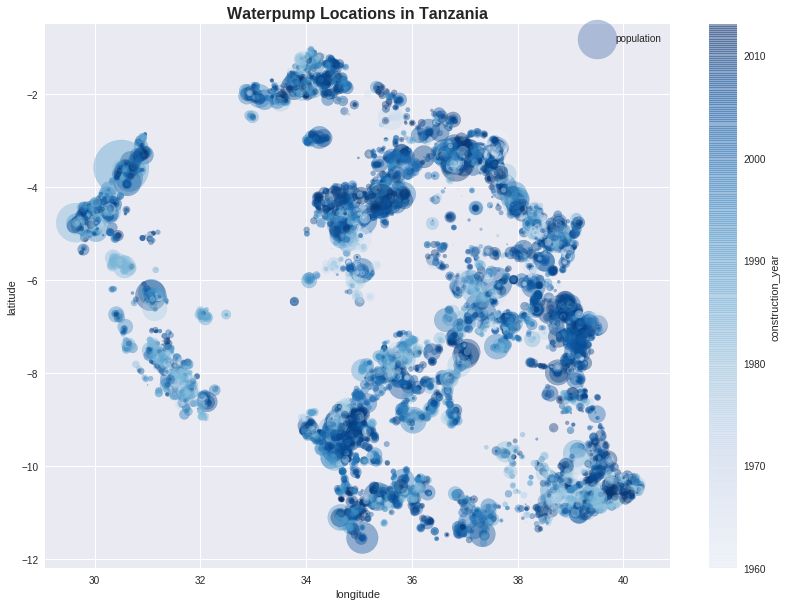

In [0]:
df_viz=train_features.copy()
df_viz[df_viz['longitude']>0] [df_viz['latitude']<0][df_viz['construction_year']>0].plot\
(kind='scatter', x="longitude", y="latitude", alpha=0.4,
s=df_viz["population"]/10, label="population", figsize=(14,10),
c="construction_year", cmap=plt.get_cmap("Blues"), colorbar=True,
sharex=False);
plt.title("Waterpump Locations in Tanzania", 
         fontsize =16, fontweight='bold')
plt.legend;

## SIMPLE BASELINE  submission using Majority Class


This gets a [**Kaggle Score**](https://www.kaggle.com/c/ds1-predictive-modeling-challenge/submissions?sortBy=date&group=all&page=1) of : ** .53754**

In [0]:
train_labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


**Look at Percentage of value counts**

In [0]:
train_labels.status_group.value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

**Establish Mode as Majority Class**

In [0]:
majority_class = train_labels.status_group.mode()[0]

**Create All Majority-class Predictions**

In [0]:
submit_df=sample_sub  ## make a copy of the sample submission df
submit_df.status_group.replace(majority_class) ## replace predicted label with majority class

**Create baseline submission**

In [0]:
submission_url = '/content/drive/My Drive/Colab Notebooks/submission.csv'
submit_df.to_csv(submission_url, index=False, header=['id','status_group'])

## Data Prep
 
 Make sure any changes made to the Training-dataset are also made to the Test-dataset

###  Combine the features and labels for data wrangling

In [0]:
df_train=pd.merge(train_features,train_labels,how='left', on=['id'])
df_test=test_features.copy()

df_train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


### Null Values and Missing Data

In [0]:
#label NaNs as unknown for One Hot Encoding as their own feature
df_train.funder.fillna('unknown', inplace=True)
df_train.permit.fillna('unknown', inplace=True)
df_train.installer.fillna('unknown', inplace=True)
df_train.subvillage.fillna('unknown', inplace=True)
df_train.scheme_name.fillna('unknown', inplace=True)
df_train.public_meeting.fillna('unknown', inplace=True)
df_train.scheme_management.fillna('unknown', inplace=True)

df_test.funder.fillna('unknown', inplace=True)
df_test.permit.fillna('unknown', inplace=True)
df_test.installer.fillna('unknown', inplace=True)
df_test.subvillage.fillna('unknown', inplace=True)
df_test.scheme_name.fillna('unknown', inplace=True)
df_test.public_meeting.fillna('unknown', inplace=True)
df_test.scheme_management.fillna('unknown', inplace=True)

In [0]:
mean_amount = df_train[df_train['amount_tsh']>0]['amount_tsh'].mean()
df_train.loc[df_train['amount_tsh']==0, 'amount_tsh'] = int(mean_amount)
mean_amount = df_test[df_test['amount_tsh']>0]['amount_tsh'].mean()
df_test.loc[df_test['amount_tsh']==0, 'amount_tsh'] = int(mean_amount)


### Drop Features that may be meaningless

In [0]:
dropped_features=['date_recorded',
                         'funder',
                      'installer',
                      'longitude',
                       'latitude',
                       'wpt_name',
                    'num_private',
                          'basin',
                     'subvillage',
                         'region',
                            'lga',
                           'ward',
                    'recorded_by',
               'scheme_management',
                    'scheme_name',
          'waterpoint_type_group',                  
                'extraction_type',
          'extraction_type_group',
          'extraction_type_class', ]

df_train.drop(columns=dropped_features, inplace=True )
df_test.drop(columns=dropped_features, inplace=True )

### One Hot Encode Features with multiple values

[CE encoder](http://contrib.scikit-learn.org/categorical-encoding/onehot.html)

SKlearn [Preprocessing](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing)


In [0]:
cols_enc=['public_meeting','management', 'management_group', 'payment','payment_type',
          'water_quality','quality_group', 'quantity',  'quantity_group'   ,'source', 'source_type','source_class','waterpoint_type','permit'  ]

df_train_enc=pd.get_dummies(df_train, columns=cols_enc, prefix=cols_enc)
df_test_enc=pd.get_dummies(df_test, columns=cols_enc, prefix=cols_enc)


df_test_enc.head(10)

,id,amount_tsh,gps_height,region_code,district_code,population,construction_year,public_meeting_False,public_meeting_True,public_meeting_unknown,management_company,management_other,management_other - school,management_parastatal,management_private operator,management_trust,management_unknown,management_vwc,management_water authority,management_water board,management_wua,management_wug,management_group_commercial,management_group_other,management_group_parastatal,management_group_unknown,management_group_user-group,payment_never pay,payment_other,payment_pay annually,payment_pay monthly,payment_pay per bucket,payment_pay when scheme fails,payment_unknown,payment_type_annually,payment_type_monthly,payment_type_never pay,payment_type_on failure,payment_type_other,payment_type_per bucket,payment_type_unknown,water_quality_coloured,water_quality_fluoride,water_quality_fluoride abandoned,water_quality_milky,water_quality_salty,water_quality_salty abandoned,water_quality_soft,water_quality_unknown,quality_group_colored,quality_group_fluoride,quality_group_good,quality_group_milky,quality_group_salty,quality_group_unknown,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,quantity_group_dry,quantity_group_enough,quantity_group_insufficient,quantity_group_seasonal,quantity_group_unknown,source_dam,source_hand dtw,source_lake,source_machine dbh,source_other,source_rainwater harvesting,source_river,source_shallow well,source_spring,source_unknown,source_type_borehole,source_type_dam,source_type_other,source_type_rainwater harvesting,source_type_river/lake,source_type_shallow well,source_type_spring,source_class_groundwater,source_class_surface,source_class_unknown,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other,permit_False,permit_True,permit_unknown
0,50785,1070.0,1996,21,3,321,2012,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
1,51630,1070.0,1569,2,2,300,2000,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0
2,17168,1070.0,1567,13,2,500,2010,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1
3,45559,1070.0,267,80,43,250,1987,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0
4,49871,500.0,1260,10,3,60,2000,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0
5,52449,1070.0,1685,2,2,200,1990,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0
6,24806,1070.0,550,11,7,600,2007,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
7,28965,1070.0,234,9,4,1,1982,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0
8,36301,30.0,584,90,33,40,1997,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0
9,54122,1070.0,1083,3,7,1,2003,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0

### Feature engineering
   
   use year_constucted to calculate age of pump

In [0]:
# Calculate construction year mean to fill missing data (year=0)
mean_year = df_train_enc[df_train_enc['construction_year']>0]['construction_year'].mean()
df_train_enc.loc[df_train_enc['construction_year']==0, 'construction_year'] = int(mean_year)

In [0]:
mean_year = df_test_enc[df_test_enc['construction_year']>0]['construction_year'].mean()
df_test_enc.loc[df_test_enc['construction_year']==0, 'construction_year'] = int(mean_year)

In [0]:
df_train_enc['age']=(2018 - df_train_enc.construction_year).astype(float)
df_test_enc['age']=(2018 - df_test_enc.construction_year).astype(float)


## Create Model Data

In [0]:
X_train = df_train_enc.drop(columns='status_group').copy()
y_train = df_train_enc.status_group.copy()

X_test = df_test_enc.copy()


In [0]:
X_train.head()


,id,amount_tsh,gps_height,region_code,district_code,population,construction_year,public_meeting_False,public_meeting_True,public_meeting_unknown,management_company,management_other,management_other - school,management_parastatal,management_private operator,management_trust,management_unknown,management_vwc,management_water authority,management_water board,management_wua,management_wug,management_group_commercial,management_group_other,management_group_parastatal,management_group_unknown,management_group_user-group,payment_never pay,payment_other,payment_pay annually,payment_pay monthly,payment_pay per bucket,payment_pay when scheme fails,payment_unknown,payment_type_annually,payment_type_monthly,payment_type_never pay,payment_type_on failure,payment_type_other,payment_type_per bucket,payment_type_unknown,water_quality_coloured,water_quality_fluoride,water_quality_fluoride abandoned,water_quality_milky,water_quality_salty,water_quality_salty abandoned,water_quality_soft,water_quality_unknown,quality_group_colored,quality_group_fluoride,quality_group_good,quality_group_milky,quality_group_salty,quality_group_unknown,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,quantity_group_dry,quantity_group_enough,quantity_group_insufficient,quantity_group_seasonal,quantity_group_unknown,source_dam,source_hand dtw,source_lake,source_machine dbh,source_other,source_rainwater harvesting,source_river,source_shallow well,source_spring,source_unknown,source_type_borehole,source_type_dam,source_type_other,source_type_rainwater harvesting,source_type_river/lake,source_type_shallow well,source_type_spring,source_class_groundwater,source_class_surface,source_class_unknown,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other,permit_False,permit_True,permit_unknown,age
0,69572,6000.0,1390,11,5,109,1999,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,19.0
1,8776,1062.0,1399,20,2,280,2010,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,8.0
2,34310,25.0,686,21,4,250,2009,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,9.0
3,67743,1062.0,263,90,63,58,1986,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,32.0
4,19728,1062.0,0,18,1,0,1996,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,22.0


In [0]:
# convert whole dataset to float64

X_train = X_train.astype('float64')
X_test = X_test.astype('float64')

In [0]:
X_train.shape

(59400, 96)

In [0]:
X_test.shape

(14358, 96)

In [0]:
X_train.head()

,id,amount_tsh,gps_height,region_code,district_code,population,construction_year,public_meeting_False,public_meeting_True,public_meeting_unknown,management_company,management_other,management_other - school,management_parastatal,management_private operator,management_trust,management_unknown,management_vwc,management_water authority,management_water board,management_wua,management_wug,management_group_commercial,management_group_other,management_group_parastatal,management_group_unknown,management_group_user-group,payment_never pay,payment_other,payment_pay annually,payment_pay monthly,payment_pay per bucket,payment_pay when scheme fails,payment_unknown,payment_type_annually,payment_type_monthly,payment_type_never pay,payment_type_on failure,payment_type_other,payment_type_per bucket,payment_type_unknown,water_quality_coloured,water_quality_fluoride,water_quality_fluoride abandoned,water_quality_milky,water_quality_salty,water_quality_salty abandoned,water_quality_soft,water_quality_unknown,quality_group_colored,quality_group_fluoride,quality_group_good,quality_group_milky,quality_group_salty,quality_group_unknown,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,quantity_group_dry,quantity_group_enough,quantity_group_insufficient,quantity_group_seasonal,quantity_group_unknown,source_dam,source_hand dtw,source_lake,source_machine dbh,source_other,source_rainwater harvesting,source_river,source_shallow well,source_spring,source_unknown,source_type_borehole,source_type_dam,source_type_other,source_type_rainwater harvesting,source_type_river/lake,source_type_shallow well,source_type_spring,source_class_groundwater,source_class_surface,source_class_unknown,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other,permit_False,permit_True,permit_unknown,age
0,69572.0,6000.0,1390.0,11.0,5.0,109.0,1999.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19.0
1,8776.0,1062.0,1399.0,20.0,2.0,280.0,2010.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0
2,34310.0,25.0,686.0,21.0,4.0,250.0,2009.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0
3,67743.0,1062.0,263.0,90.0,63.0,58.0,1986.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,32.0
4,19728.0,1062.0,0.0,18.0,1.0,0.0,1996.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,22.0


In [0]:
X_test.head()

,id,amount_tsh,gps_height,region_code,district_code,population,construction_year,public_meeting_False,public_meeting_True,public_meeting_unknown,management_company,management_other,management_other - school,management_parastatal,management_private operator,management_trust,management_unknown,management_vwc,management_water authority,management_water board,management_wua,management_wug,management_group_commercial,management_group_other,management_group_parastatal,management_group_unknown,management_group_user-group,payment_never pay,payment_other,payment_pay annually,payment_pay monthly,payment_pay per bucket,payment_pay when scheme fails,payment_unknown,payment_type_annually,payment_type_monthly,payment_type_never pay,payment_type_on failure,payment_type_other,payment_type_per bucket,payment_type_unknown,water_quality_coloured,water_quality_fluoride,water_quality_fluoride abandoned,water_quality_milky,water_quality_salty,water_quality_salty abandoned,water_quality_soft,water_quality_unknown,quality_group_colored,quality_group_fluoride,quality_group_good,quality_group_milky,quality_group_salty,quality_group_unknown,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,quantity_group_dry,quantity_group_enough,quantity_group_insufficient,quantity_group_seasonal,quantity_group_unknown,source_dam,source_hand dtw,source_lake,source_machine dbh,source_other,source_rainwater harvesting,source_river,source_shallow well,source_spring,source_unknown,source_type_borehole,source_type_dam,source_type_other,source_type_rainwater harvesting,source_type_river/lake,source_type_shallow well,source_type_spring,source_class_groundwater,source_class_surface,source_class_unknown,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other,permit_False,permit_True,permit_unknown,age
0,50785.0,1070.0,1996.0,21.0,3.0,321.0,2012.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,6.0
1,51630.0,1070.0,1569.0,2.0,2.0,300.0,2000.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,18.0
2,17168.0,1070.0,1567.0,13.0,2.0,500.0,2010.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,8.0
3,45559.0,1070.0,267.0,80.0,43.0,250.0,1987.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,31.0
4,49871.0,500.0,1260.0,10.0,3.0,60.0,2000.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,18.0


## Attempt 2  :  using SKlearn -  LogisticRegression 

 SKLearn [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) Docs
 
 [2 WAYS TO IMPLEMENT MULTINOMIAL LOGISTIC REGRESSION IN PYTHON](http://dataaspirant.com/2017/05/15/implement-multinomial-logistic-regression-python/)
 
This gets a [**Kaggle Score**](https://www.kaggle.com/c/ds1-predictive-modeling-challenge/submissions?sortBy=date&group=all&page=1) of : ** .72558** 

In [0]:
#mul_lr = LogisticRegression(multi_class='auto', solver='newton-cg').fit(X_train, y_train)
mul_lr = LogisticRegression().fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


### Run prediction and create submission csv

In [0]:
lr_pred=mul_lr.predict(X_test)

In [0]:
submission_url = '/content/drive/My Drive/Colab Notebooks/submission.csv'
pyx.create_kaggle_submission(lr_pred,X_test,submission_url)

In [0]:
dir(pyx)

['VERSION',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'create_kaggle_submission',
 'pd',
 'train_test_split',
 'train_validation_test_split']

In [0]:
pyx([4,5,6,7,8])

TypeError: ignored

##Attempt 3 : Cross-Validated Pipeline : RobustScaler-SelectKBest-LogisticRegression
This gets a [**Kaggle Score**](https://www.kaggle.com/c/ds1-predictive-modeling-challenge/submissions?sortBy=date&group=all&page=1) of : ** .69424**

Docs for [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) [scoring parameter](https://scikit-learn.org/stable/modules/model_evaluation.html)



In [0]:
pipe = make_pipeline(
    RobustScaler(),  
    SelectKBest(f_classif), 
    LogisticRegression())

In [0]:
# select hyper-parameters 
param_grid = {
    'selectkbest__k': [1,2,3], 
    'logisticregression__class_weight': [None, 'balanced'],
    }


# Fit on the train set   3-folds,  scoring=accuracy
gs = GridSearchCV(pipe, param_grid=param_grid, cv=3, 
                  scoring='accuracy', 
                  iid=False,
                  verbose=1)

gs.fit(X_train, y_train)
gs_preds=gs.predict(X_test)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sk

In [0]:
submission_url = '/content/drive/My Drive/Colab Notebooks/submission.csv'
pyx.create_kaggle_submission(gs_preds,X_test,submission_url)


## Attempt 4 :  Random Forest
This gets a [**Kaggle Score**](https://www.kaggle.com/c/ds1-predictive-modeling-challenge/submissions?sortBy=date&group=all&page=1) of : ** .79704**

In [0]:
from sklearn.ensemble import RandomForestClassifier
m = RandomForestClassifier(n_estimators=200,min_samples_leaf=3 ,n_jobs=-1,max_features=0.25)
%time m.fit(X_train, y_train)
m_preds= m.predict(X_test)

CPU times: user 52.4 s, sys: 245 ms, total: 52.7 s
Wall time: 26.8 s


In [0]:
submission_url = '/content/drive/My Drive/Colab Notebooks/submission.csv'
pyx.create_kaggle_submission(m_preds,X_test,submission_url)

## Attempt 5 :  RobustScaler + Random Forest
This gets a [**Kaggle Score**](https://www.kaggle.com/c/ds1-predictive-modeling-challenge/submissions?sortBy=date&group=all&page=1) of : ** .79718  ***  **

In [0]:
X=X_train.copy()
transformer = RobustScaler().fit(X)
transformer.transform(X)

In [0]:
m = RandomForestClassifier(n_estimators=200,min_samples_leaf=3 ,n_jobs=-1,max_features=0.25)
%time m.fit(X, y_train)
m_preds= m.predict(X_test)

In [0]:
submission_url = '/content/drive/My Drive/Colab Notebooks/submission.csv'
pyx.create_kaggle_submission(m_preds,X_test,submission_url)

## Attempt 6 : RobustScaler + SKlearn.ensemble.GradientBoostingClassifier 

This gets a [**Kaggle Score**](https://www.kaggle.com/c/ds1-predictive-modeling-challenge/submissions?sortBy=date&group=all&page=1) of : ** .74453**


In [0]:
X=X_train.copy()
transformer = RobustScaler().fit(X)
transformer.transform(X)

In [0]:
gboost=GradientBoostingClassifier(loss='deviance',
                           learning_rate=0.1,
                           n_estimators=100,
                           subsample=1.0,
                           criterion='friedman_mse',
                           min_samples_split=2,
                           min_samples_leaf=1,
                           min_weight_fraction_leaf=0.0,
                           max_depth=3,
                           min_impurity_decrease=0.0,
                           min_impurity_split=None,
                           init=None, random_state=None,
                           max_features=None,
                           verbose=0,
                           max_leaf_nodes=None,
                           warm_start=False,
                           presort='auto',
                           validation_fraction=0.1,
                           n_iter_no_change=None,
                           tol=0.0001  )
gboost.fit(X, y_train)
gboost_preds= gboost.predict(X_test)


In [0]:
submission_url = '/content/drive/My Drive/Colab Notebooks/submission.csv'
create_submission(gboost_preds,X_test,submission_url)

## Attempt :SKlearn.ensemble.Ada Boost Classifier





In [0]:
estimator = RandomForestClassifier(n_estimators=200,min_samples_leaf=3 ,n_jobs=-1,max_features=0.25)
booster = AdaBoostClassifier(estimator)
%time booster.fit(X, y_train)
booster_preds= booster.predict(X_test)

CPU times: user 56min 14s, sys: 19.3 s, total: 56min 33s
Wall time: 28min 54s


In [0]:
submission_url = '/content/drive/My Drive/Colab Notebooks/submission.csv'
pyx.create_kaggle_submission(booster_preds,X_test,submission_url)

## Attempt  : SUPPORT VECTOR MACHINE 


SVM CLASSIFIER, INTRODUCTION TO [SUPPORT VECTOR MACHINE ALGORITHM](https://dataaspirant.com/2017/01/13/support-vector-machine-algorithm/)


In [0]:
X=X_train.copy()
transformer = RobustScaler().fit(X)
transformer.transform(X)

## Comparison

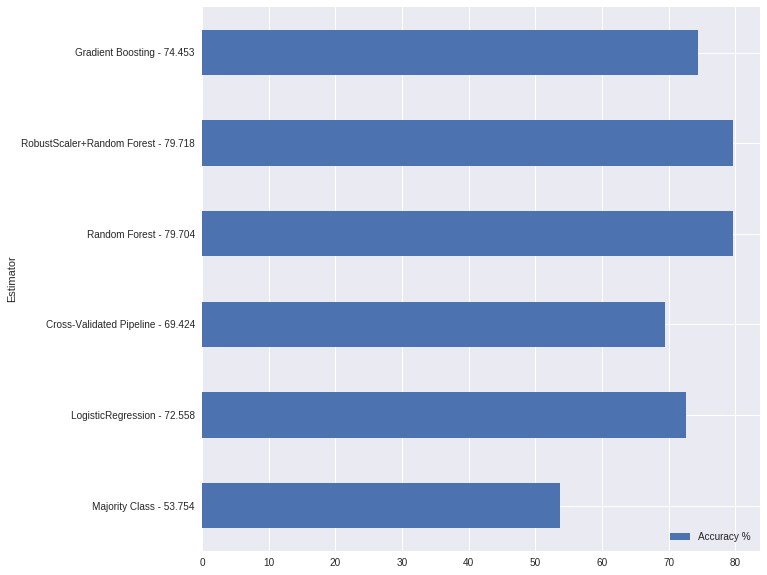

In [0]:
estimat=pd.DataFrame(['Majority Class - 53.754','LogisticRegression - 72.558','Cross-Validated Pipeline - 69.424','Random Forest - 79.704','RobustScaler+Random Forest - 79.718','Gradient Boosting - 74.453'],columns=['Estimator'])
scores=pd.DataFrame([53.754, 72.558, 69.424, 79.704, 79.718, 74.453 ],columns=['Accuracy %'])
results=pd.concat([estimat, scores], axis=1)
results.set_index('Estimator',inplace=True)
results.plot.barh(figsize=(10,10))